In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score,r2_score,mean_absolute_error,mean_squared_error,accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from plotly.offline import iplot, init_notebook_mode
import pickle
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
from datetime import datetime
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:

path = '../../../Atliq Marts Challenge'
fact_order_lines_df=pd.read_csv(path+"/fact_order_lines.csv")
# fact_orders_aggregate_df=pd.read_csv("Atliq Marts Challenge/fact_orders_aggregate.csv")

dim_date=pd.read_csv(path+"/dim_date.csv")
dim_customers=pd.read_csv(path+"/dim_customers.csv")
dim_products=pd.read_csv(path+"/dim_products.csv")
dim_targets_orders=pd.read_csv(path+"/dim_targets_orders.csv")

dim_date=pd.read_csv(path+"/dim_date.csv")

dim_date = dim_date.rename(columns={'date': 'agreed_delivery_date','mmm_yy': 'agreed_delivery_mmm_yy','week_no': 'agreed_delivery_week_no'})


In [3]:
# result =  pd.concat([fact_order_lines_df, fact_orders_aggregate_df], axis=1,join="outer")
# result =pd.merge( fact_order_lines_df, fact_orders_aggregate_df, on=["order_id", "customer_id"])
# esult =pd.merge( fact_order_lines_df, fact_orders_aggregate_df, on=["order_id", "customer_id"])
result =pd.merge( fact_order_lines_df ,dim_customers , how="outer",on=["customer_id"])
result =pd.merge( result ,dim_products , how="outer",on=["product_id"])
train_SC =pd.merge( result ,dim_targets_orders , how="outer",on=["customer_id"])
train_SC =pd.merge( result ,dim_targets_orders , how="outer",on=["customer_id"])
train_SC =pd.merge( result ,dim_date , how="outer",on=["agreed_delivery_date"])

In [4]:
train_SC.columns = [col.lower().replace(' ', '_') for col in train_SC.columns]
train_SC.rename(columns=lambda x: x.replace("(", "").replace(")", ""), inplace=True)
train_SC.rename(columns=lambda x: x.replace("%", "_percent"), inplace=True)

In [5]:
train_SC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57097 entries, 0 to 57096
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 57096 non-null  object 
 1   order_placement_date     57096 non-null  object 
 2   customer_id              57096 non-null  float64
 3   product_id               57096 non-null  float64
 4   order_qty                57096 non-null  float64
 5   agreed_delivery_date     57097 non-null  object 
 6   actual_delivery_date     57096 non-null  object 
 7   delivery_qty             57096 non-null  float64
 8   in_full                  57096 non-null  float64
 9   on_time                  57096 non-null  float64
 10  on_time_in_full          57096 non-null  float64
 11  customer_name            57096 non-null  object 
 12  city                     57096 non-null  object 
 13  product_name             57096 non-null  object 
 14  category              

In [6]:
# train_SC[train_SC['customer_id'] == 789201].to_csv('output789201.csv', index=False)

In [7]:
df = train_SC[(train_SC['product_id'] == 25891101)|(train_SC['product_id'] == 25891102)|(train_SC['product_id'] == 25891103)] 
# df = train_SC[(train_SC['customer_id'] == 789201) & (train_SC['product_id'] == 25891103)] 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9520 entries, 14 to 57054
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 9520 non-null   object 
 1   order_placement_date     9520 non-null   object 
 2   customer_id              9520 non-null   float64
 3   product_id               9520 non-null   float64
 4   order_qty                9520 non-null   float64
 5   agreed_delivery_date     9520 non-null   object 
 6   actual_delivery_date     9520 non-null   object 
 7   delivery_qty             9520 non-null   float64
 8   in_full                  9520 non-null   float64
 9   on_time                  9520 non-null   float64
 10  on_time_in_full          9520 non-null   float64
 11  customer_name            9520 non-null   object 
 12  city                     9520 non-null   object 
 13  product_name             9520 non-null   object 
 14  category              

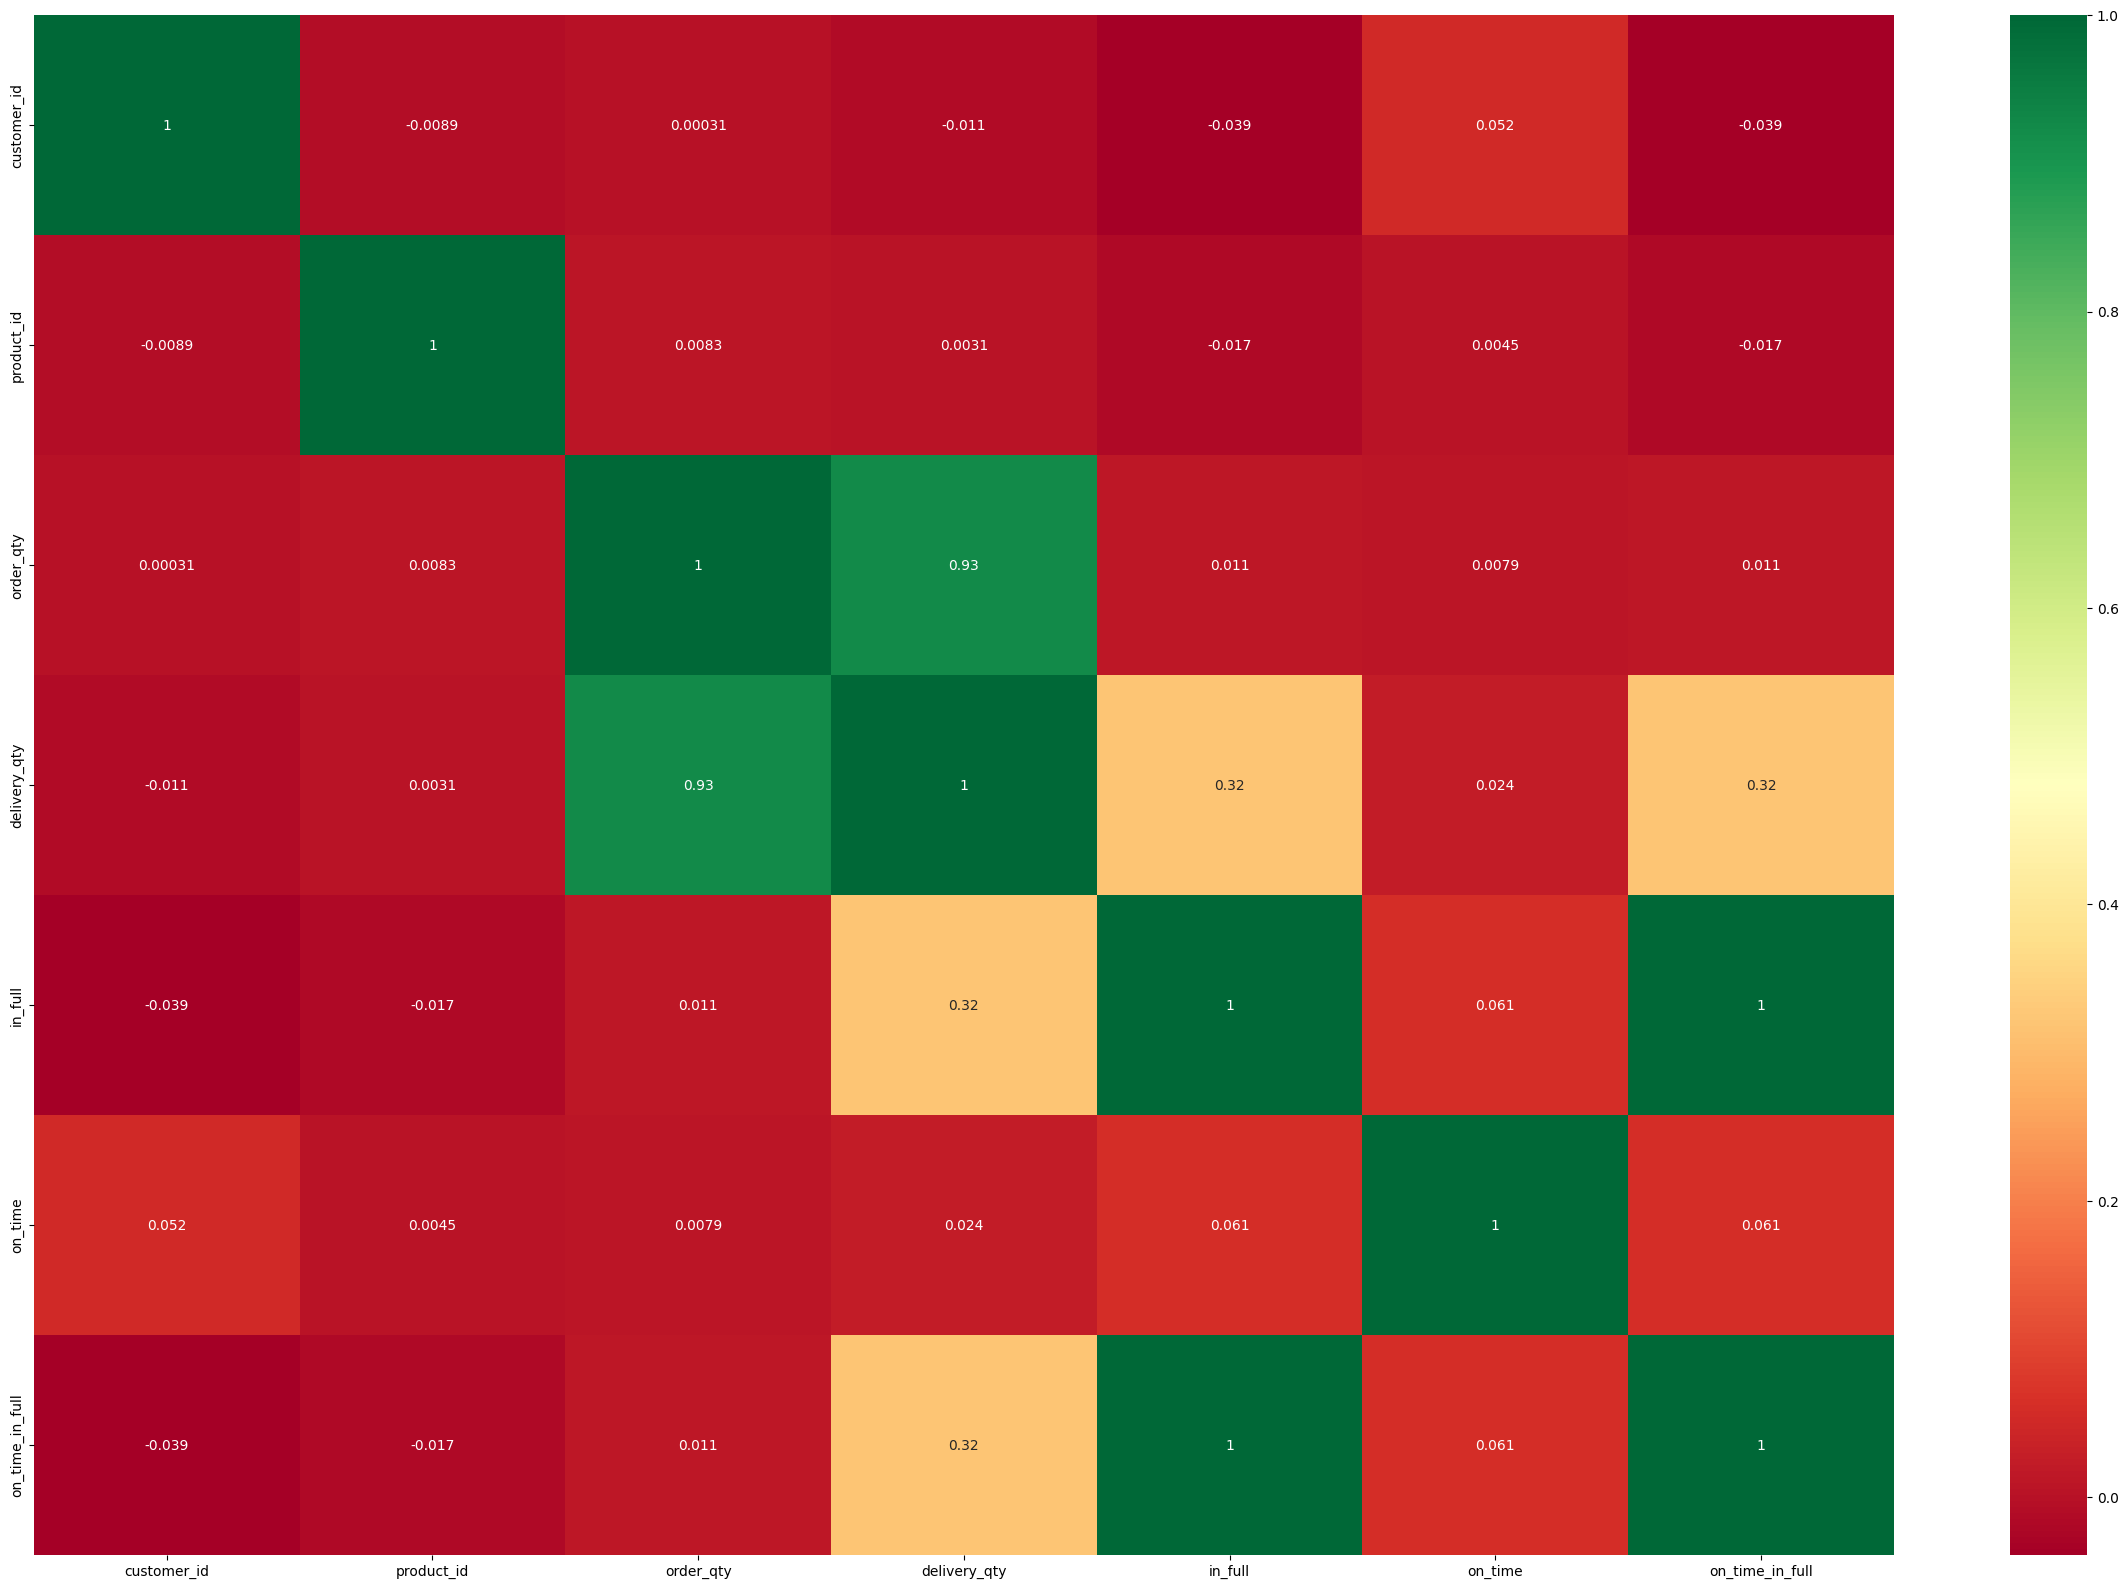

In [9]:
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['float64', 'int64']).columns

# Drop non-numeric columns
SCData_numeric = df.drop(columns=non_numeric_columns)

# Compute correlation matrix
corrmap = SCData_numeric.corr()
top=corrmap.index
plt.figure(figsize=(30,20))
g=sns.heatmap(df[top].corr(),annot=True,cmap="RdYlGn")

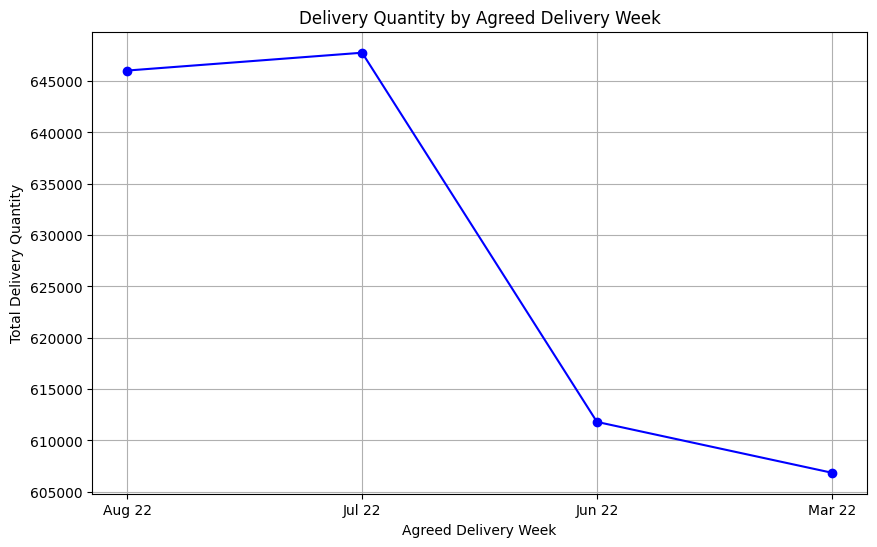

In [10]:

# Assuming selected_rows is your DataFrame

# Convert 'actual_delivery_date' to datetime format
df['agreed_delivery_date_formatted'] = pd.to_datetime(df['agreed_delivery_date'], format='%d-%b-%y')
df = df.sort_values(by='agreed_delivery_date_formatted')
# Group by 'agreed_delivery_week_no' and calculate the sum of order quantities
df_weekly_sum = df.groupby('agreed_delivery_mmm_yy')['order_qty'].sum().reset_index()[1:-1]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_weekly_sum['agreed_delivery_mmm_yy'], df_weekly_sum['order_qty'], color='blue', marker='o', linestyle='-')
plt.title('Delivery Quantity by Agreed Delivery Week')
plt.xlabel('Agreed Delivery Week')
plt.ylabel('Total Delivery Quantity')
plt.grid(True)
plt.show()


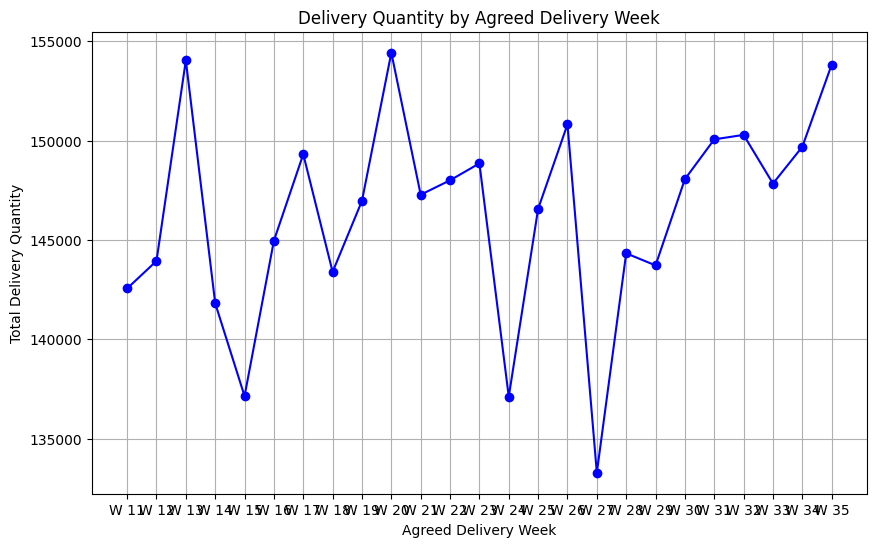

In [11]:

# Assuming selected_rows is your DataFrame

# Convert 'actual_delivery_date' to datetime format
df['agreed_delivery_date_formatted'] = pd.to_datetime(df['agreed_delivery_date'], format='%d-%b-%y')
df = df.sort_values(by='agreed_delivery_date_formatted')
# Group by 'agreed_delivery_week_no' and calculate the sum of order quantities
df_weekly_sum = df.groupby('agreed_delivery_week_no')['order_qty'].sum().reset_index()[1:-1]

# # Plot
plt.figure(figsize=(10, 6))
plt.plot(df_weekly_sum['agreed_delivery_week_no'], df_weekly_sum['order_qty'], color='blue', marker='o', linestyle='-')

plt.title('Delivery Quantity by Agreed Delivery Week')
plt.xlabel('Agreed Delivery Week')
plt.ylabel('Total Delivery Quantity')
plt.grid(True)
plt.show()

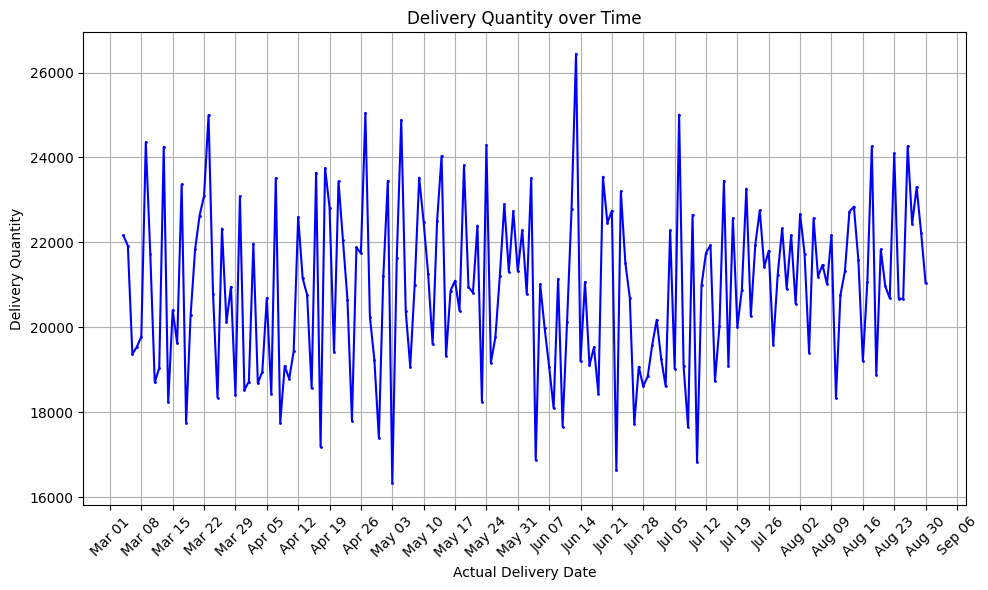

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming selected_rows is your DataFrame

# Convert 'actual_delivery_date' to datetime format
df['agreed_delivery_date_formatted'] = pd.to_datetime(df['agreed_delivery_date'], format='%d-%b-%y')
df = df.sort_values(by='agreed_delivery_date_formatted')
# Group by 'agreed_delivery_week_no' and calculate the sum of order quantities
df_weekly_sum = df.groupby('agreed_delivery_date_formatted')['order_qty'].sum().reset_index()[2:-1]

# df_weekly_sum.info()
# # Plot
# plt.figure(figsize=(10, 6))
# plt.plot(df_weekly_sum['agreed_delivery_date_formatted'], df_weekly_sum['order_qty'], color='blue', marker='o', linestyle='-')
# plt.title('Delivery Quantity by Agreed Delivery Week')
# plt.xlabel('Agreed Delivery Week')
# plt.ylabel('Total Delivery Quantity')
# plt.grid(True)
# plt.show()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_weekly_sum['agreed_delivery_date_formatted'], df_weekly_sum['order_qty'], color='blue', marker='o', linestyle='-', markersize=1)

plt.title('Delivery Quantity over Time')
plt.xlabel('Actual Delivery Date')
plt.ylabel('Delivery Quantity')
plt.grid(True)

# Set x-axis major ticks to represent weeks
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [13]:

# # Assuming selected_rows is your DataFrame

# # Convert 'actual_delivery_date' to datetime format
# df['agreed_delivery_date_formatted'] = pd.to_datetime(df['agreed_delivery_date'], format='%d-%b-%y')

# # Sort DataFrame by 'actual_delivery_date_formatted'
# df_sorted = df.sort_values(by='agreed_delivery_date_formatted')

# # Plot
# plt.figure(figsize=(10, 6))
# plt.plot(df_sorted['agreed_delivery_date_formatted'], df_sorted['order_qty'], color='blue', marker='o', linestyle='-', markersize=1)
# plt.title('Delivery Quantity over Time')
# plt.xlabel('Actual Delivery Date')
# plt.ylabel('Delivery Quantity')
# plt.grid(True)

# # Set x-axis major ticks to represent weeks
# plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.tight_layout()  # Adjust layout to prevent clipping of labels
# plt.show()
